# MeOH synthesis model comparison (Grabow vs RMG)

Source for grabow model:  
Grabow, L. C., & Mavrikakis, M. (2011). Mechanism of methanol synthesis on cu through CO2 and CO hydrogenation. ACS Catalysis, 1(4), 365–384. https://doi.org/10.1021/cs200055d

In [1]:
import pandas as pd
import numpy as np
import time
import cantera as ct
from matplotlib import pyplot as plt
import csv
import math
import os
import sys
from IPython.display import Image

import itertools
import logging
from collections import defaultdict

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


## Experimental Conditions for Graaf spinning basket reactor study.

Graaf, G. H., Stamhuis, E. J., & Beenackers, A. A. C. M. (1988). Kinetics of low-pressure methanol synthesis. Chemical Engineering Science, 43(12), 3185–3195. https://doi.org/10.1016/0009-2509(88)85127-3


In [2]:

Image(filename='images/Graaf_Experimental_Conditions.png',width = 700, height = 300) 

FileNotFoundError: [Errno 2] No such file or directory: 'images/Graaf_Experimental_Conditions.png'

## Experimental Conditions for Graaf spinning basket reactor study (PhD thesis).

Graaf, Geert. (2016). The Synthesis of methanol in Gas-Solid and Gas-Slurry Reactors - PhD Thesis, 1988. 10.13140/RG.2.1.1002.8402. 


In [3]:

Image(filename='images/Graaf_PhD_Experimental_Conditions.png',width = 600, height = 300) 

FileNotFoundError: [Errno 2] No such file or directory: 'images/Graaf_PhD_Experimental_Conditions.png'

In [4]:
Image(filename='images/spinning_basket_reactor_Graff.png')

FileNotFoundError: [Errno 2] No such file or directory: 'images/spinning_basket_reactor_Graff.png'

## Graaf reactor specifications
pp 260-269: 2 Phase reactor Conditions
catalyst weights used: 4.24, 1.36, 7.97, 1.53 g catalyst used for their experiments

$\frac{10^{3}\phi_v}{W}$ volume flow rate at T=298.15K, P = 1.013 bar. per kg catalyst

pp 63 ID of reactor and height are 70mm each 

## Industrial conditions
temp =  230-280C.  
pressure = 50-120 atm.   
CO/CO2/H2 = 10/10/80.    

In [11]:
# Grabow model and RMG input files
cti_file_rmg = '../../base/cantera/chem_annotated.cti'


# cti_file_rmg = 'Grabow_species_removed/chem_annotated_removed.cti'



#constants
pi = math.pi

# set initial temps, pressures, concentrations
# temp = 230+273.15 # kelvin
temp = 528 # kelvin
pressure = 75*ct.one_atm # Pascals
X_co = 0.1
X_co2= 0.1
X_h2 = 0.8
mw_co = 28.01e-3  # [kg/mol]
mw_co2 = 44.01e-3 # [kg/mol]
mw_h2 = 1.01e-3 # [kg/mol]

# CO/CO2/H2/H2O: typical is 
concentrations_rmg = {'CO(3)': X_co,'CO2(4)': X_co2, 'H2(2)':X_h2}

# initialize cantera gas and surface
gas= ct.Solution(cti_file_rmg,'gas')

# surf_grab = ct.Interface(cti_file,'surface1_grab', [gas_grab])
surf = ct.Interface(cti_file_rmg,'surface1', [gas])

# gas_grab.TPX = 
gas.TPX = temp, pressure, concentrations_rmg
surf.TP = temp, pressure
surf.coverages = 'X(1):1.0'

# create gas inlet
inlet = ct.Reservoir(gas)

#create gas outlet
exhaust = ct.Reservoir(gas)

# Reactor volume
rradius = 35e-3
rlength = 70e-3
rvol = (rradius**2)*pi*rlength

# Catalyst Surface Area
site_density = surf.site_density*1000                #[mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_weight = 4.24e-3                                 #[kg]
cat_site_per_wt = (300*1e-6)*1000                    #[mol/kg] 1e-6mol/micromole, 1000g/kg
cat_area = 100*site_density/(cat_weight*cat_site_per_wt) #[m^3]

# reactor initialization
r = ct.IdealGasReactor(gas, energy='off')
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
r.volume = rvol

# flow controllers (Graaf measured flow at 293.15 and 1 atm)
volume_flow = 0.00424                                               # [m^3/s]
molar_flow = volume_flow*pressure/(8.3145*temp)               # [mol/s]
mass_flow = molar_flow*(X_co*mw_co+X_co2*mw_co2) # [kg/s]
mfc = ct.MassFlowController(inlet, r, mdot=mass_flow)

# initialize reactor network
sim = ct.ReactorNet([r])
# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-11
sim.atol = 1.0e-22

#for debugging
sim.verbose = True
sim.reinitialize()

print(cat_area)

CanteraError: 
***********************************************************************
CanteraError thrown by InterfaceKinetics::addReaction:
Number of surface sites not balanced in reaction CO2(4) + 2 X(1) <=> CO2X(51).
Reactant sites: 2
Product sites: 1
***********************************************************************


In [84]:
for i in range(0, surf.n_reactions):
     if 'C2HOX(465)' in str(surf.reaction_equation(i)):
        print(surf.reaction_equation(i), i)
        surf.set_multiplier(0.1,i)
        
for i in range(0, surf.n_reactions):
     if 'H2X(50)' in str(surf.reaction_equation(i)):
        print(surf.reaction_equation(i), i)
        surf.set_multiplier(0.01,i)
        


H2(2) + X(1) <=> H2X(50) 60
H2X(50) + O*(11) <=> H*(10) + OH*(12) 61
CO*(14) + H2X(50) <=> H*(10) + HCO*(16) 62
CO2*(15) + H2X(50) <=> H*(10) + HCOO*(17) 63
CO2*(15) + H2X(50) <=> COOH*(18) + H*(10) 64
CH2O*(19) + H2X(50) <=> CH3O*(20) + H*(10) 65
CH2O2X(51) + H2X(50) <=> CH3O2*(21) + H*(10) 89
CH2O*(19) + H2X(50) <=> CH3OX(46) + H*(10) 109
CH2O2X(51) + H2X(50) <=> CH3O2X(49) + H*(10) 139
CH2OX(169) + H2X(50) <=> CH3OX(46) + H*(10) 178
CHOX(168) + H2X(50) <=> CH2OX(169) + H*(10) 198
H2X(50) + SX(436) <=> H*(10) + SX(262) 288
C2HOX(464) + H2X(50) <=> H*(10) + SX(436) 312
H2X(50) + SX(318) <=> H*(10) + SX(357) 373
H2X(50) + SX(1093) <=> H*(10) + SX(1139) 481
H2X(50) + SX(1093) <=> H*(10) + SX(217) 524
H2X(50) + SX(923) <=> H*(10) + SX(572) 570
H2X(50) + SX(1337) <=> H*(10) + SX(923) 607
H2X(50) + SX(55) <=> H*(10) + SX(156) 843
H2X(50) + SX(1407) <=> H*(10) + SX(538) 942
H2X(50) + SX(2673) <=> H*(10) + SX(1407) 1127
H2X(50) + SX(539) <=> H*(10) + SX(495) 1202


## Grabow Values Given

300 $\mu$mol(sites)/g(catalyst).

Automatically created module for IPython interactive environment


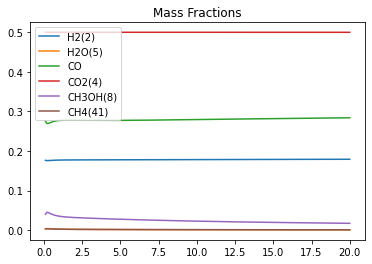

In [85]:
output_filename = f'Results_single.csv'
outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['time(s)','T (C)', 'P (atm)'] 
                + gas.species_names + surf.species_names,)

t = 0.0
dt = 0.1

# Setup solution array"
states = ct.SolutionArray(gas, extra=['t'])

while t < 20.0:
    t += dt
    sim.advance(t)
    states.append(r.thermo.state, t=t)
    writer.writerow([t,temp, pressure] +
                 list(gas.X) + list(surf.X),)

if __name__ == '__main__':
    print(__doc__)
    try:
        import matplotlib.pyplot as plt
        plt.figure(1)
        plt.plot(states.t, states('H2(2)', 'H2O(5)', 'CO(3)','CO2(4)','CH3OH(8)','CH4(41)').Y)
        plt.title('Mass Fractions')
        plt.legend(["H2(2)", "H2O(5)","CO","CO2(4)","CH3OH(8)","CH4(41)"])
        plt.show()
    except ImportError:
        print('Matplotlib not found. Unable to plot results.')
        


In [72]:
# sim.advance_to_steady_state(max_steps=100000,residual_threshold=sim.rtol*2,return_residuals=True)
# writer.writerow([temp, pressure, 'V (M^3/s)', 'X_co initial','X_co initial','X_co initial', gas.T] +
#                  list(gas.X) + list(surf.X),)

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

results = pd.read_csv('Results_single.csv')
max_dist = 2
imp_reactions = []
imprxn_max = []
imprxn_min = []

df_short = results

print('\n Reactions with ROP that spikes between 1.5 and 1.8:', '\n')
for i in range (6, len(df_short.columns)):
    
    column = df_short[df_short.columns[i]]
    dist = df_short[df_short.columns[0]]
    max_value = column.max()
    max_index = column.idxmax()
    min_value = column.min()
    min_index = column.idxmin()
    

# 1.5 <= dist[min_index] <= 1.74 and 
    if max_value >= 1e-4 and (("X" in df_short.columns[i]) or ("Pt" in df_short.columns[i]) or ("Pd" in df_short.columns[i]) or ("*" in df_short.columns[i])):
            
        imp_reactions.append(df_short.columns[i])
        imprxn_max.append(max_value)
        imprxn_min.append(min_value)
        print(df_short.columns[i], "Max = " "{:.10f}".format(max_value))
        
    elif min_value <= -1e-4 and (("X" in df_short.columns[i]) or ("Pt" in df_short.columns[i]) or ("Pd" in df_short.columns[i]) or ("*" in df_short.columns[i])):
        
        imp_reactions.append(df_short.columns[i])
        print(df_short.columns[i], "Min = " "{:.10f}".format(min_value))
        imprxn_max.append(max_value)
        imprxn_min.append(min_value)


 Reactions with ROP that spikes between 1.5 and 1.8: 

X(1) Max = 0.0689746518
H*(10) Max = 0.0055733478
CO*(14) Max = 0.0880864058
HCO*(16) Max = 0.0042891625
CH3OH*(22) Max = 0.0018078807
CH3OX(46) Max = 0.0001049535
H2X(50) Max = 0.8361431642
CH4X(238) Max = 0.0074541304
C2HOX(464) Max = 0.3429319456


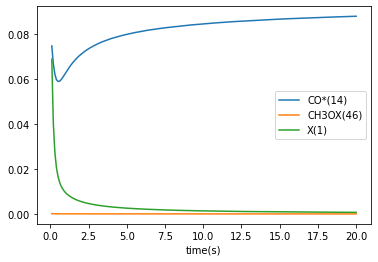

In [74]:
results = pd.read_csv('Results_single.csv')
results.plot('time(s)',['CO*(14)','CH3OX(46)', 'X(1)'])

In [75]:
def save_flux_diagrams(*phases, suffix=''):
    """
    Saves the flux diagrams. The filenames have a suffix if provided,
    so you can keep them separate and not over-write.
    """
    for element in 'CHONX':
        for phase_object in phases:
            phase = phase_object.name

            diagram = ct.ReactionPathDiagram(phase_object, element)
            diagram.title = f'Reaction path diagram following {element} in {phase}'
            diagram.label_threshold = 0.01

            dot_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.dot"
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            img_path = os.path.join(os.getcwd(), img_file)
            diagram.write_dot(dot_file)
            #print(diagram.get_data())

            print(f"Wrote graphviz input file to '{os.path.join(os.getcwd(), dot_file)}'.")
            os.system(f'dot {dot_file} -Tpng -o{img_file} -Gdpi=200')
            print(f"Wrote graphviz output file to '{img_path}'.")

def show_flux_diagrams(*phases, suffix='', embed=False):
    """
    Shows the flux diagrams in the notebook.
    Loads them from disk.
    Does not embed them, to keep the .ipynb file small,
    unless embed=True. Use embed=True if you might over-write the files,
    eg. you want to show flux at different points.
    """
    import IPython
    for element in 'CHONX':
        for phase_object in phases:
            phase = phase_object.name
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            display(IPython.display.HTML(f'<hr><h2>{element} {phase}</h2>'))
            if embed:
                display(IPython.display.Image(filename=img_file,width=400,embed=True))
            else:
                display(IPython.display.Image(url=img_file,width=400,embed=False))

In [76]:
save_flux_diagrams(gas)

Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_C_gas.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_C_gas.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_H_gas.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_H_gas.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_O_gas.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_O_gas.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_N_gas.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_N_gas.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulati

In [77]:
save_flux_diagrams(surf)

Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_C_surface1.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_C_surface1.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_H_surface1.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_H_surface1.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_O_surface1.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_O_surface1.png'.
Wrote graphviz input file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_N_surface1.dot'.
Wrote graphviz output file to '/work/westgroup/ChrisB/meOH-synthesis/cantera_simulations/reaction_path_N_surface1.png'.
Wrote graphviz input file to '/work/westgrou

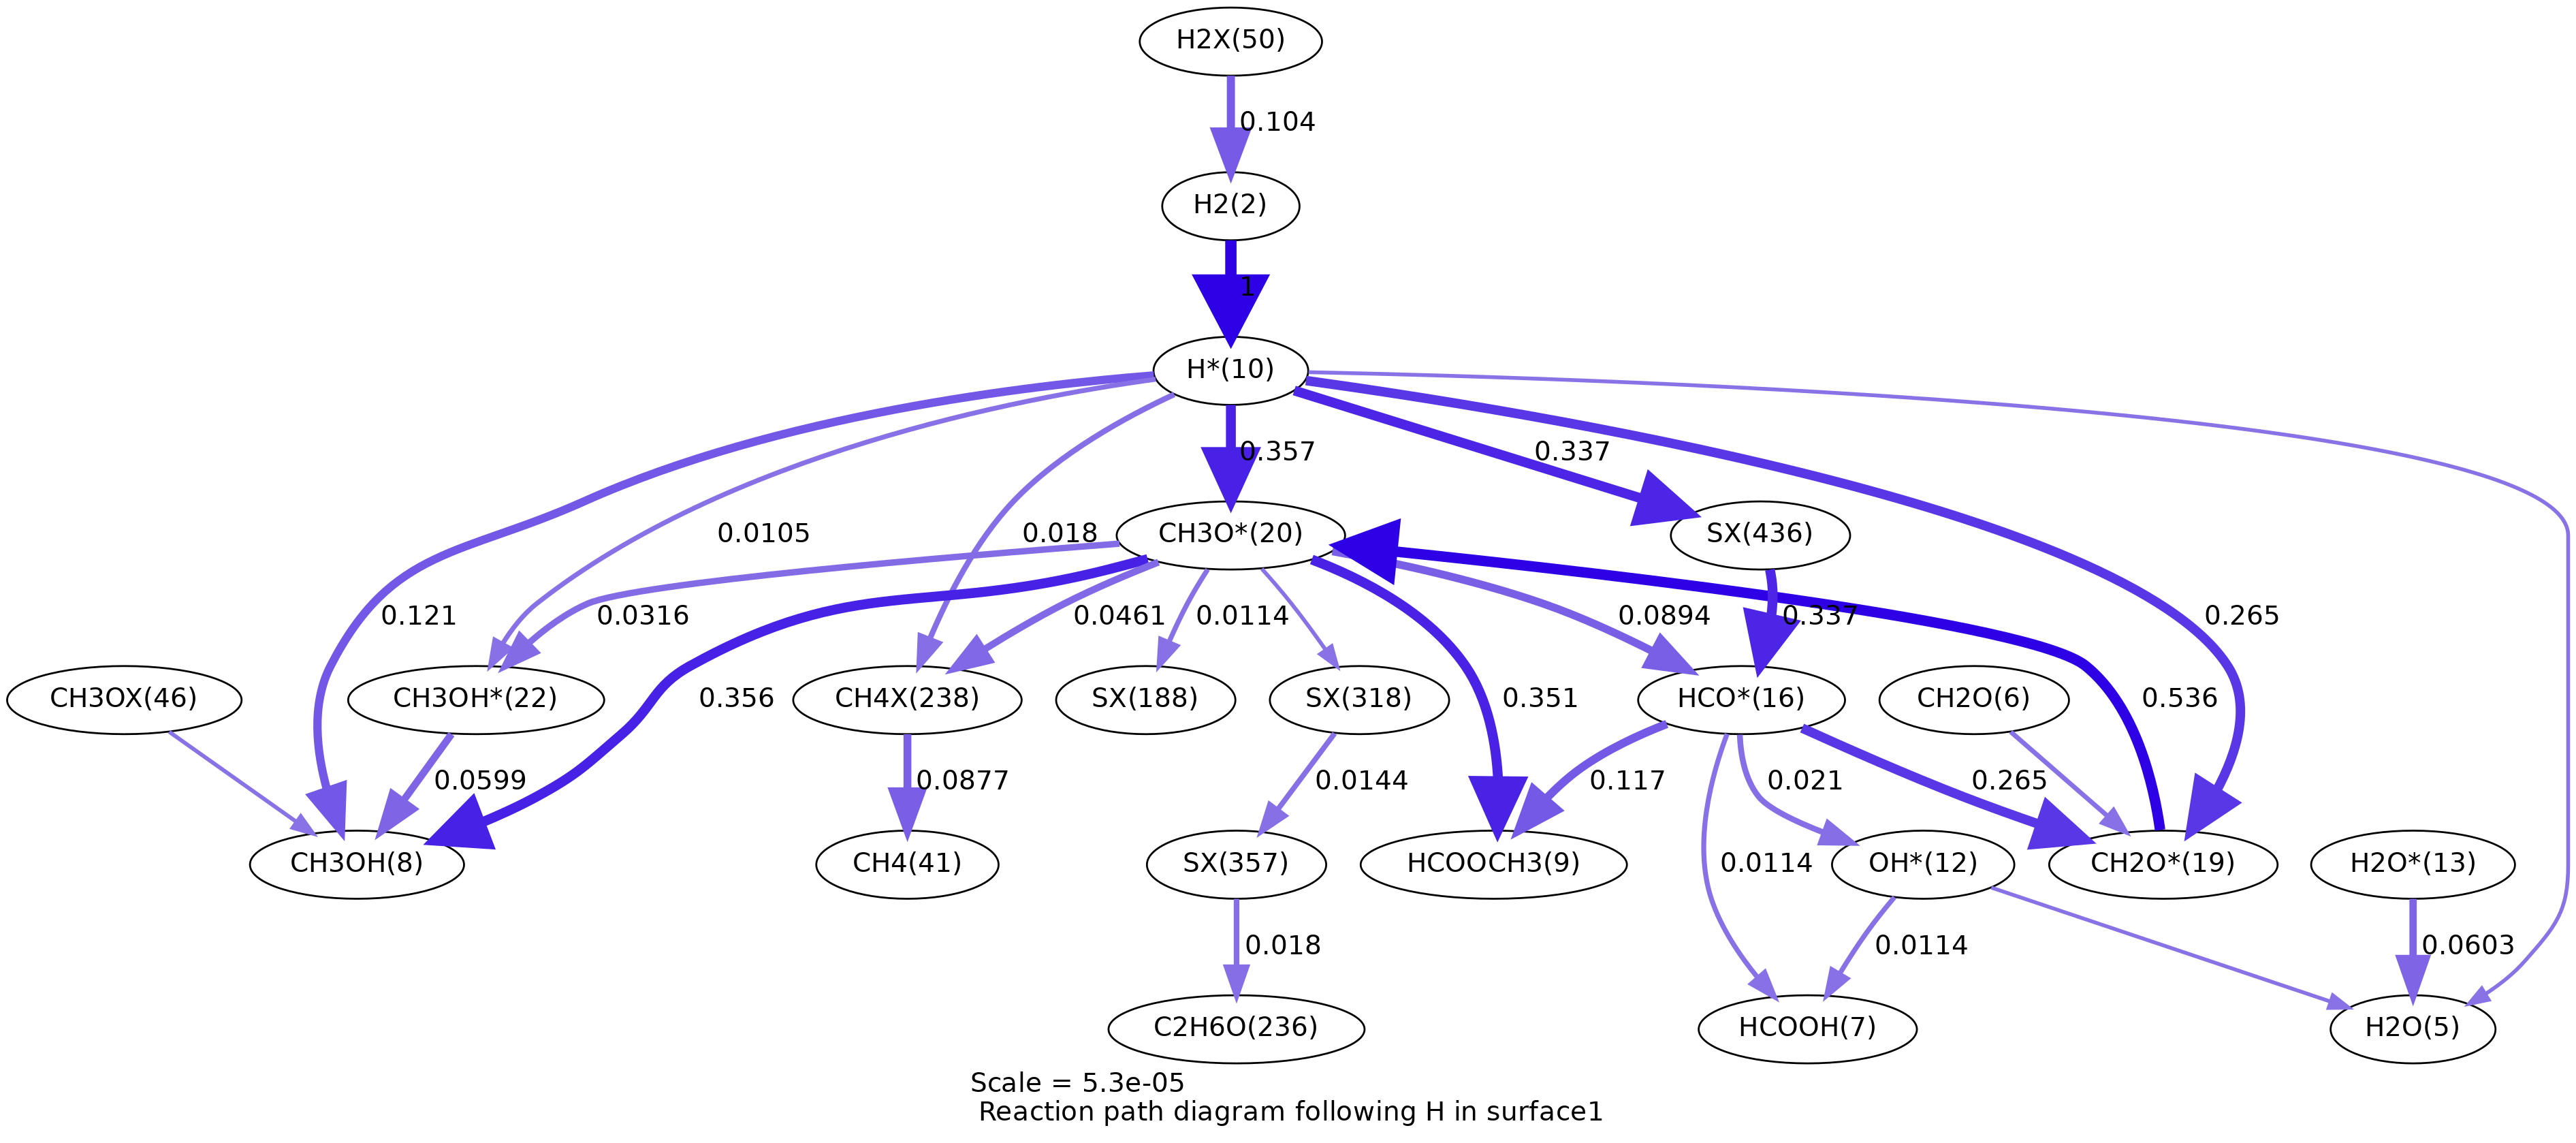

In [81]:
Image(filename='reaction_path_H_surface1.png')

In [7]:
# Report the highest rates in reaction
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rates_of_progress[i]:8.1g}")

report_rates()


Highest net rates of progress, gas
  6 : CO2(4) + H2(2) <=> HCOOH(7)                          9e-23
  5 : CO2(4) + H2(2) <=> HCOOH(7)                          9e-23
  3 : CO2(4) + H2(2) <=> HCOOH(7)                          9e-23
  1 : CO(3) + H2(2) <=> CH2O(6)                            5e-26
 16 : CO2(4) + OCCO(227) <=> S(580)                            0
 15 : C2H6O(236) + CO2(4) <=> S(500)                           0
 14 : CH3OH(8) + CO(3) <=> C2H4O2(63)                          0

Highest net rates of progress, surface
 61 : H2(2) + X(1) <=> H2X(50)                             5e+01
  1 : H2(2) + 2 X(1) <=> 2 H*(10)                          2e+01
  2 : CO(3) + X(1) <=> CO*(14)                                 9
 10 : CO2(4) + X(1) <=> CO2*(15)                           2e-07
550 : CH2O2X(51) + SX(188) <=> CO*(14) + SX(217)               0
540 : HCOO*(17) + SX(1122) <=> O*(11) + SX(1172)               0
541 : CH2O*(19) + SX(1122) <=> H*(10) + SX(1172)               0

Highest forwa

In [1]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
        print(surf.reaction(i).is_sticking_coefficient)
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, surface


NameError: name 'np' is not defined

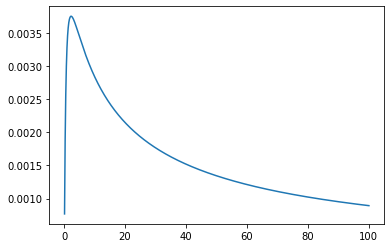

In [96]:
# plt.plot(states.t, states('CO2(4)','CH3OH(8)', 'H2(2)','CH4(41)','HCOOCH3(9)').Y)
# plt.legend(["CO2","CH3OH(8)","H2(2)", "CH4(41)","HCOOCH3(8)"])
plt.plot(states.t, states('CH4(41)').Y)


In [41]:
#################################################
# Run single reactor 
#################################################

output_filename = f'Grabow_Results_RMG.csv'
outfile = open(output_filename,'a')
writer = csv.writer(outfile)
# writer.writerow(['T (C)', 'P (atm)', 'V (M^3/s)', 'X_co initial','X_co initial','X_co initial', 'T (C) final'] +
#                 gas.species_names + surf.species_names,)

t = 0.0
dt = 0.1
# sim.max_err_test_fails = 1e6

while t < 100000.0:
    t += dt
    sim.advance(t)

writer.writerow([temp, pressure, volume_flow, X_co, X_co2, X_h2o, gas.T] +
                 list(gas.X) + list(surf.X),)
    


2513

In [44]:
3**6

729

In [ ]:
X_cos = [0.053, 0.1365, 0.220] 
X_co2s = [0.261,0.1205, 0.261]
X_h2s = [0.625, 0.7625, 0.900]

In [48]:
mid = (0.625 + 0.900)/2
print(mid)

0.7625


In [30]:
# Temps = [483.7,499.3,516.7]
Temps = [528]
# Pressures = [15,30,50]
Pressures = [75]
# volume_flows = [0.00424,0.0106,0.02544]
volume_flows = [0.02544]

# CO+CO2/H2
CO_H2_ratio = [0.8,0.5,0.95]

#CO2/CO
CO_CO2_ratio = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 

settings  = list(itertools.product(Temps,
                                   Pressures,
                                   volume_flows,
                                   CO_H2_ratio,
                                   CO_CO2_ratio
                                  ))
print(len(settings))

27


In [29]:
surf['CH3OH(8)'].net_production_rates

ValueError: No such species 'CH3OH(8)'.

In [36]:
surf.n_reactions

1536

In [57]:
for i in range(0, surf.n_reactions):
     if 'CH3OH(' in str(surf.reaction_equation(i)):
         print(surf.reaction_equation(i))
        

CH3OH(8) + 2 X(1) <=> CH3O*(20) + H*(10)
CH3OH(8) + X(1) <=> CH3OH*(22)
CH3OH(8) + 2 X(1) <=> CH3OX(46) + H*(10)
CH3OH(8) + 2 X(1) <=> CH3X(52) + OH*(12)


In [58]:
for i in range(0, surf.n_reactions):
     if 'CH3O*(20)' in str(surf.reaction_equation(i)):
         print(surf.reaction_equation(i))

CH2O(6) + H*(10) <=> CH3O*(20)
CH3OH(8) + 2 X(1) <=> CH3O*(20) + H*(10)
HCOOCH3(9) + 2 X(1) <=> CH3O*(20) + HCO*(16)
CH3O*(20) + H*(10) <=> CH3OH*(22) + X(1)
CH2O*(19) + H*(10) <=> CH3O*(20) + X(1)
CH3OH*(22) + O*(11) <=> CH3O*(20) + OH*(12)
CH3OH*(22) + O*(11) <=> CH3O*(20) + OH*(12)
CH2O*(19) + OH*(12) <=> CH3O*(20) + O*(11)
CH2O*(19) + H2O*(13) <=> CH3O*(20) + OH*(12)
CH3O*(20) + HCO*(16) <=> CH3OH*(22) + CO*(14)
CH3OH*(22) + CO2*(15) <=> CH3O*(20) + HCOO*(17)
CH3OH*(22) + CO2*(15) <=> CH3O*(20) + COOH*(18)
CH2O*(19) + HCO*(16) <=> CH3O*(20) + CO*(14)
2 CH2O*(19) <=> CH3O*(20) + HCO*(16)
CH2O*(19) + CH2O2X(51) <=> CH3O*(20) + HCOO*(17)
CH2O*(19) + CH2O2X(51) <=> CH3O*(20) + COOH*(18)
CH2O2X(51) + CH3OH*(22) <=> CH3O*(20) + CH3O2*(21)
CH3O*(20) <=> CH3OX(46)
CH2O*(19) + CH3OH*(22) <=> CH3O*(20) + CH3OX(46)
CH2O*(19) + CH3OH*(22) <=> CH3O*(20) + CH3OX(46)
CH3O*(20) + X(1) <=> CH3X(52) + O*(11)
CH4X(238) + O*(11) <=> CH3O*(20) + H*(10)
CH2O*(19) + CH4X(238) <=> CH3O*(20) + CH3X(52)
CH2